# AI 201 Mini Project
## Coffee Match: Leveraging Machine Learning for Coffee Bean Recommendations Using Taste Profiles
### Exploratory Data Analysis on the Coffee Quality Institute 2018 Dataset

Submitted by: 
Jan Lendl R. Uy, 2019-00312

### Download the necessary packages

In [1]:
%pip install pandas seaborn matplotlib numpy imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

### Load the dataset as a dataframe

In [3]:
df = pd.read_csv("datasets/merged_data_cleaned.csv")

In [4]:
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


### Format column names in snake-case

In [5]:
# Function to convert to snake case
def to_snake_case(name):
    # Replace dots and spaces with underscore
    name = name.replace('.', '_').replace(' ', '_')
    # Remove any double underscores
    name = name.replace('__', '_')
    # Convert to lowercase
    return name.lower()

In [6]:
# Get current columns and create a mapping dictionary
column_mapping = {col: to_snake_case(col) for col in df.columns}

# Rename the columns
df = df.rename(columns=column_mapping)

In [7]:
print(df.columns)

Index(['unnamed:_0', 'species', 'owner', 'country_of_origin', 'farm_name',
       'lot_number', 'mill', 'ico_number', 'company', 'altitude', 'region',
       'producer', 'number_of_bags', 'bag_weight', 'in_country_partner',
       'harvest_year', 'grading_date', 'owner_1', 'variety',
       'processing_method', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points',
       'total_cup_points', 'moisture', 'category_one_defects', 'quakers',
       'color', 'category_two_defects', 'expiration', 'certification_body',
       'certification_address', 'certification_contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')


In [8]:
columns_to_drop = [
    "owner",
    "owner_1",
    "grading_date",
    "unnamed:_0",  # unnamed index column
    "certification_address", 
    "certification_contact",
    "ico_number",
    "lot_number",
    "expiration",
    "altitude", # No need since this is a range
    "altitude_low_meters", # No need since average is already specified in altitude_mean_meters
    "altitude_high_meters", # No need since average is already specified in altitude_mean_meters
    "in_country_partner",
    "unit_of_measurement"
]

cleaned_df = df.drop(columns_to_drop, axis=1)

In [9]:
print(cleaned_df.columns)

Index(['species', 'country_of_origin', 'farm_name', 'mill', 'company',
       'region', 'producer', 'number_of_bags', 'bag_weight', 'harvest_year',
       'variety', 'processing_method', 'aroma', 'flavor', 'aftertaste',
       'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness',
       'cupper_points', 'total_cup_points', 'moisture', 'category_one_defects',
       'quakers', 'color', 'category_two_defects', 'certification_body',
       'altitude_mean_meters'],
      dtype='object')


### Remove mean altitudes that are $>8848 m$
This is not possible. Highest elevation above sea level is the peak of Mount Everest, which is at 8,848 meters.

In [10]:
# Print statistics before cleaning
print("Before cleaning:")
print("Number of values above 8,848m:", len(cleaned_df[cleaned_df['altitude_mean_meters'] > 8848]))
print("Maximum altitude:", cleaned_df['altitude_mean_meters'].max())
print("Total non-null values:", cleaned_df['altitude_mean_meters'].count())

# Replace values above 8,848m with NaN
cleaned_df['altitude_mean_meters'] = cleaned_df['altitude_mean_meters'].apply(
    lambda x: np.nan if pd.notnull(x) and x > 8848 else x
)

# Print statistics after cleaning
print("\nAfter cleaning:")
print("Number of values above 8,848m:", len(cleaned_df[cleaned_df['altitude_mean_meters'] > 8848]))
print("Maximum altitude:", cleaned_df['altitude_mean_meters'].max())
print("Total non-null values:", cleaned_df['altitude_mean_meters'].count())

# Show some examples of rows where values were changed
print("\nRows where altitude was set to NaN (showing original altitude_mean_meters):")
mask = cleaned_df['altitude_mean_meters'] > 8848
if len(cleaned_df[mask]) > 0:
    print(cleaned_df[mask][['country_of_origin', 'altitude_mean_meters', 'altitude_mean_meters', 'unit_of_measurement']])
else:
    print("No values were found above 8,848m")

# Basic statistics of the cleaned altitude column
print("\nStatistics of cleaned standardized altitude:")
print(cleaned_df['altitude_mean_meters'].describe())

Before cleaning:
Number of values above 8,848m: 4
Maximum altitude: 190164.0
Total non-null values: 1109

After cleaning:
Number of values above 8,848m: 0
Maximum altitude: 4287.0
Total non-null values: 1105

Rows where altitude was set to NaN (showing original altitude_mean_meters):
No values were found above 8,848m

Statistics of cleaned standardized altitude:
count    1105.000000
mean     1327.765497
std       486.357350
min         1.000000
25%      1100.000000
50%      1310.640000
75%      1600.000000
max      4287.000000
Name: altitude_mean_meters, dtype: float64


## Initial exploratory data analysis

In [11]:
# Basic information about the dataset
print(cleaned_df.info())  # Data types and null values
print(cleaned_df.describe())  # Statistical summary of numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   species               1339 non-null   object 
 1   country_of_origin     1338 non-null   object 
 2   farm_name             980 non-null    object 
 3   mill                  1021 non-null   object 
 4   company               1130 non-null   object 
 5   region                1280 non-null   object 
 6   producer              1107 non-null   object 
 7   number_of_bags        1339 non-null   int64  
 8   bag_weight            1339 non-null   object 
 9   harvest_year          1292 non-null   object 
 10  variety               1113 non-null   object 
 11  processing_method     1169 non-null   object 
 12  aroma                 1339 non-null   float64
 13  flavor                1339 non-null   float64
 14  aftertaste            1339 non-null   float64
 15  acidity              

In [12]:
# Check for missing values
print(cleaned_df.isnull().sum())

species                   0
country_of_origin         1
farm_name               359
mill                    318
company                 209
region                   59
producer                232
number_of_bags            0
bag_weight                0
harvest_year             47
variety                 226
processing_method       170
aroma                     0
flavor                    0
aftertaste                0
acidity                   0
body                      0
balance                   0
uniformity                0
clean_cup                 0
sweetness                 0
cupper_points             0
total_cup_points          0
moisture                  0
category_one_defects      0
quakers                   1
color                   270
category_two_defects      0
certification_body        0
altitude_mean_meters    234
dtype: int64


### Remove row of columns with 1 NaN

In [13]:
cleaned_df = cleaned_df.dropna(subset=["country_of_origin"])  # Drop row with NaN since in country_of_rows there is only 1
cleaned_df = cleaned_df.dropna(subset=["quakers"])  # Drop row with NaN since in quakers there is only 1

### Cupper Points per Region

/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_75740/1861039207.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_first,
/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_75740/1861039207.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_75740/1861039207.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_second,
/var/folders/cq/5p30h6x5741g3nvfdq8t32g40000gn/T/ipykernel_75740/1861039207.py:56: UserWarning: set_ticklabels() should only be 

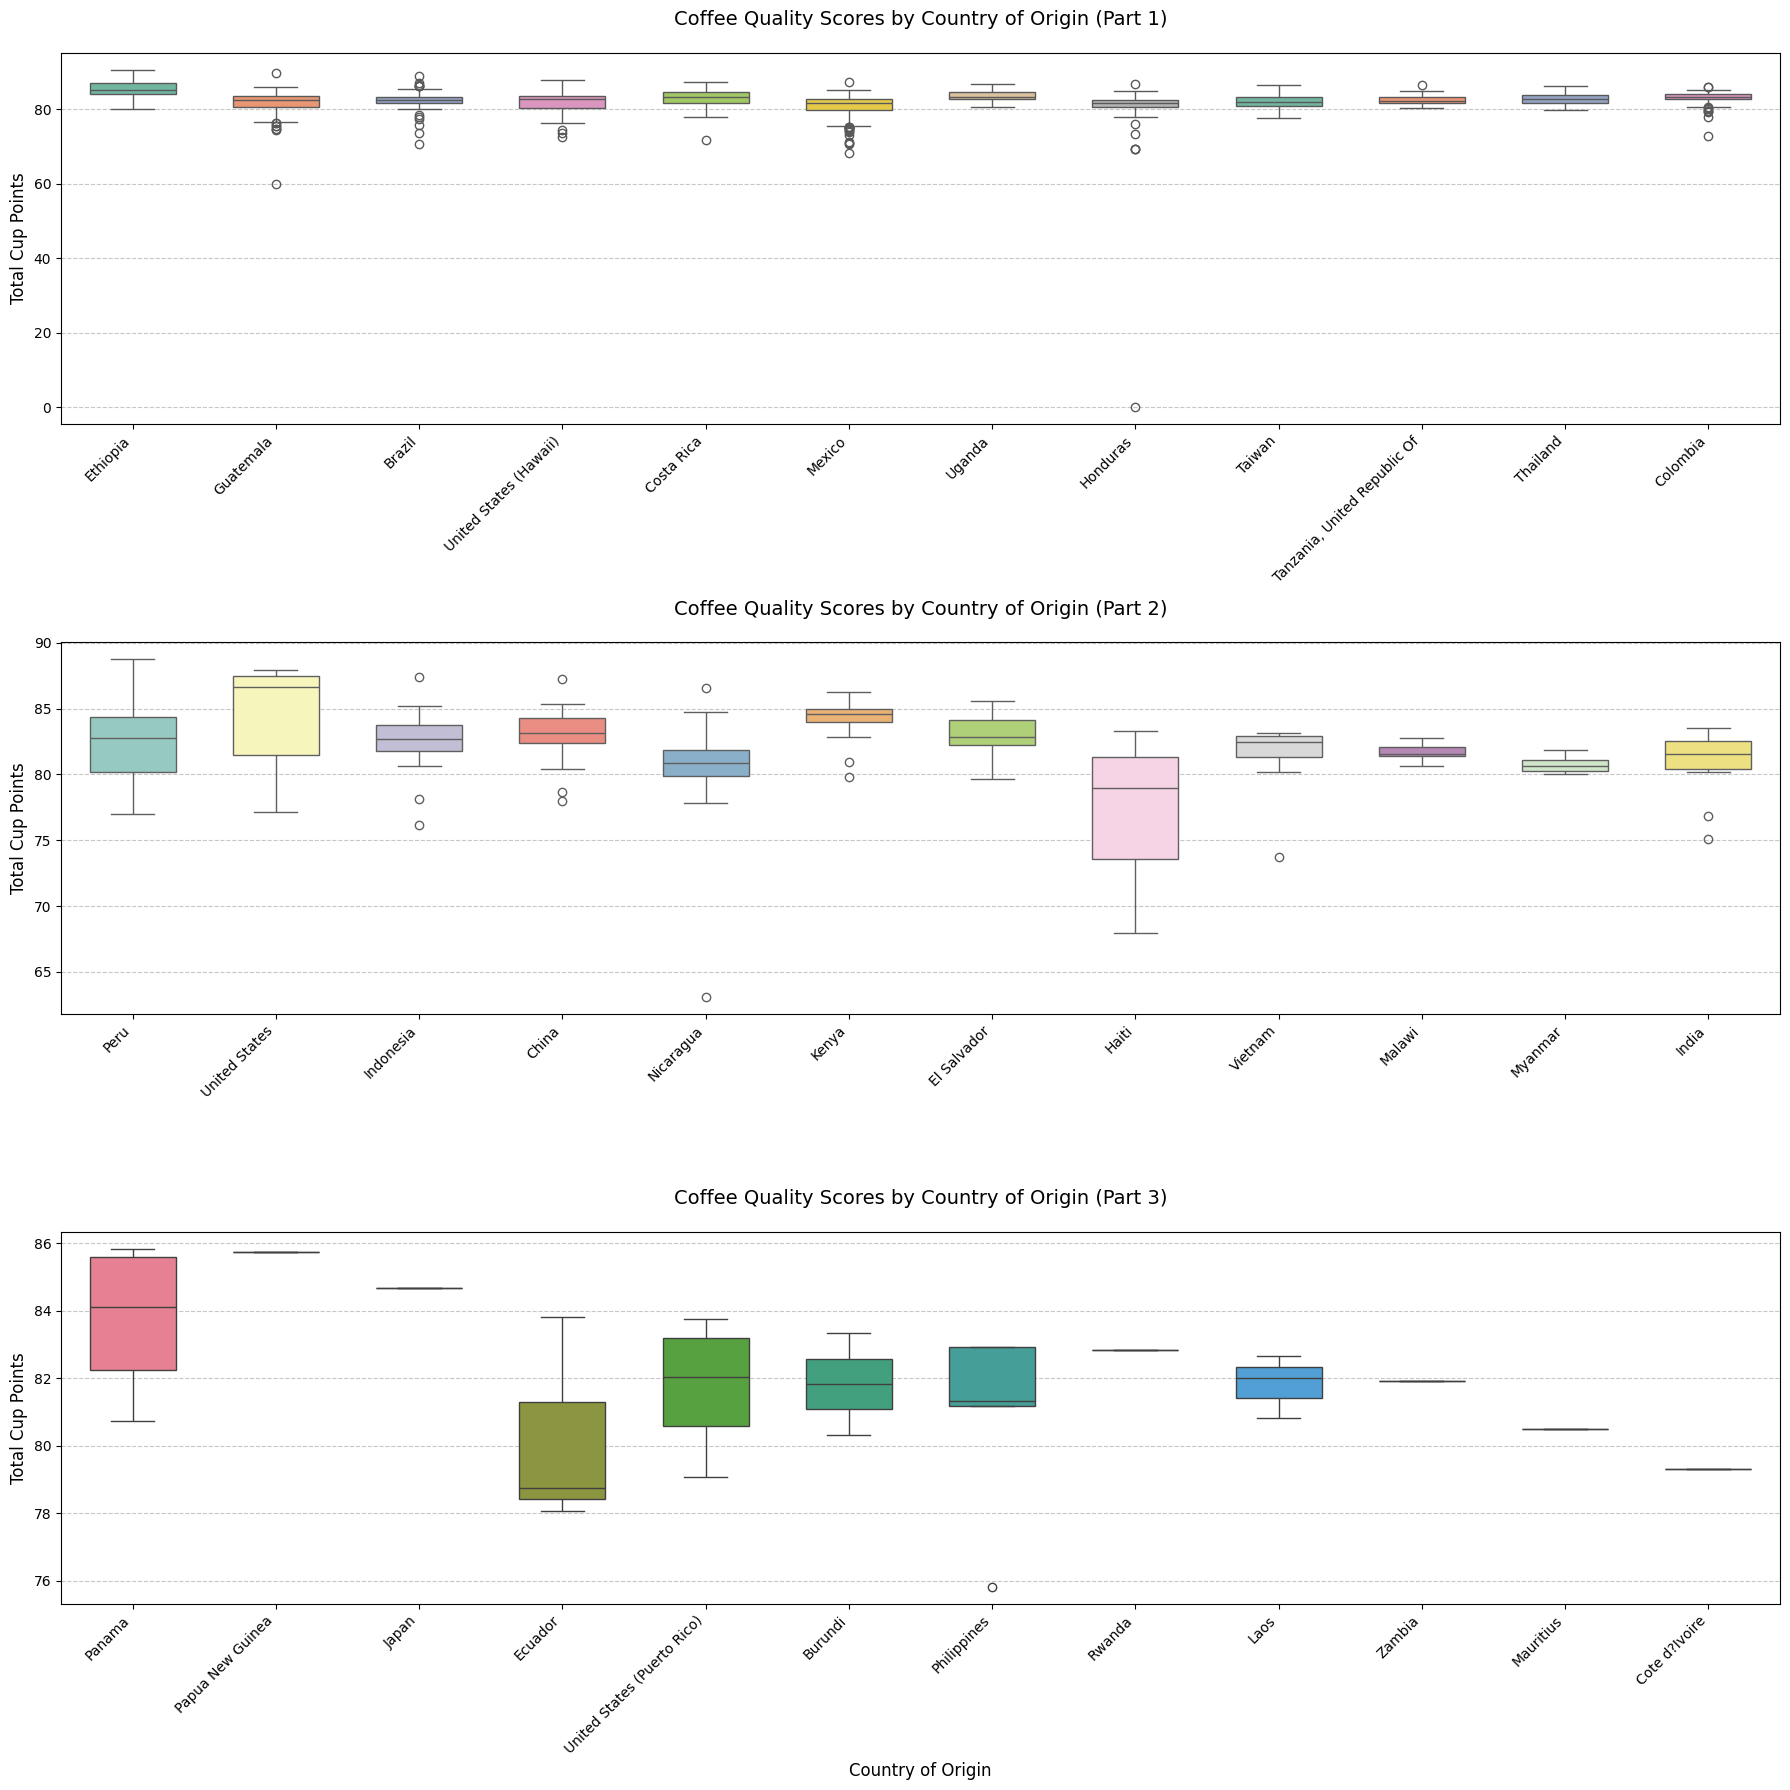


Number of samples per country:
country_of_origin
Mexico                          236
Colombia                        182
Guatemala                       181
Brazil                          132
Taiwan                           75
United States (Hawaii)           73
Honduras                         53
Costa Rica                       51
Ethiopia                         44
Tanzania, United Republic Of     40
Uganda                           36
Thailand                         32
Nicaragua                        26
Kenya                            25
El Salvador                      21
Indonesia                        20
China                            16
India                            14
Malawi                           11
United States                    10
Peru                             10
Myanmar                           8
Vietnam                           8
Haiti                             6
Philippines                       5
United States (Puerto Rico)       4
Panama        

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get country counts and sort them
country_counts = cleaned_df['country_of_origin'].value_counts()

# Split countries into three groups
split_point = len(country_counts) // 3
first_third = country_counts.index[:split_point]
second_third = country_counts.index[split_point:2*split_point]
last_third = country_counts.index[2*split_point:]

# Create three filtered dataframes
df_first = cleaned_df[cleaned_df['country_of_origin'].isin(first_third)]
df_second = cleaned_df[cleaned_df['country_of_origin'].isin(second_third)]
df_third = cleaned_df[cleaned_df['country_of_origin'].isin(last_third)]

# Create a color palette
colors_first = sns.color_palette("Set2", n_colors=len(first_third))
colors_second = sns.color_palette("Set3", n_colors=len(second_third))
colors_third = sns.color_palette("husl", n_colors=len(last_third))

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 18))

# First plot
sns.boxplot(data=df_first, 
            x='country_of_origin', 
            y='total_cup_points',
            palette=colors_first,
            width=0.6,
            ax=ax1)

# Customize first plot
ax1.set_title('Coffee Quality Scores by Country of Origin (Part 1)', pad=20, fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Total Cup Points', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
# ax1.set_ylim(55, 95)

# Second plot
sns.boxplot(data=df_second, 
            x='country_of_origin', 
            y='total_cup_points',
            palette=colors_second,
            width=0.6,
            ax=ax2)

# Customize second plot
ax2.set_title('Coffee Quality Scores by Country of Origin (Part 2)', pad=20, fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Total Cup Points', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
# ax2.set_ylim(55, 95)

# Third plot
sns.boxplot(data=df_third, 
            x='country_of_origin', 
            y='total_cup_points',
            palette=colors_third,
            width=0.6,
            ax=ax3)

# Customize third plot
ax3.set_title('Coffee Quality Scores by Country of Origin (Part 3)', pad=20, fontsize=14)
ax3.set_xlabel('Country of Origin', fontsize=12)
ax3.set_ylabel('Total Cup Points', fontsize=12)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.grid(axis='y', linestyle='--', alpha=0.7)
# ax3.set_ylim(55, 95)

# Adjust layout
plt.tight_layout()
plt.show()

# Print sample sizes for reference
print("\nNumber of samples per country:")
print(country_counts)

### Correlation matrix of coffee taste profiles

Numeric columns: ['number_of_bags', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points', 'total_cup_points', 'moisture', 'category_one_defects', 'quakers', 'category_two_defects', 'altitude_mean_meters']

Categorical columns: ['species', 'country_of_origin', 'farm_name', 'mill', 'company', 'region', 'producer', 'bag_weight', 'harvest_year', 'variety', 'processing_method', 'color', 'certification_body']


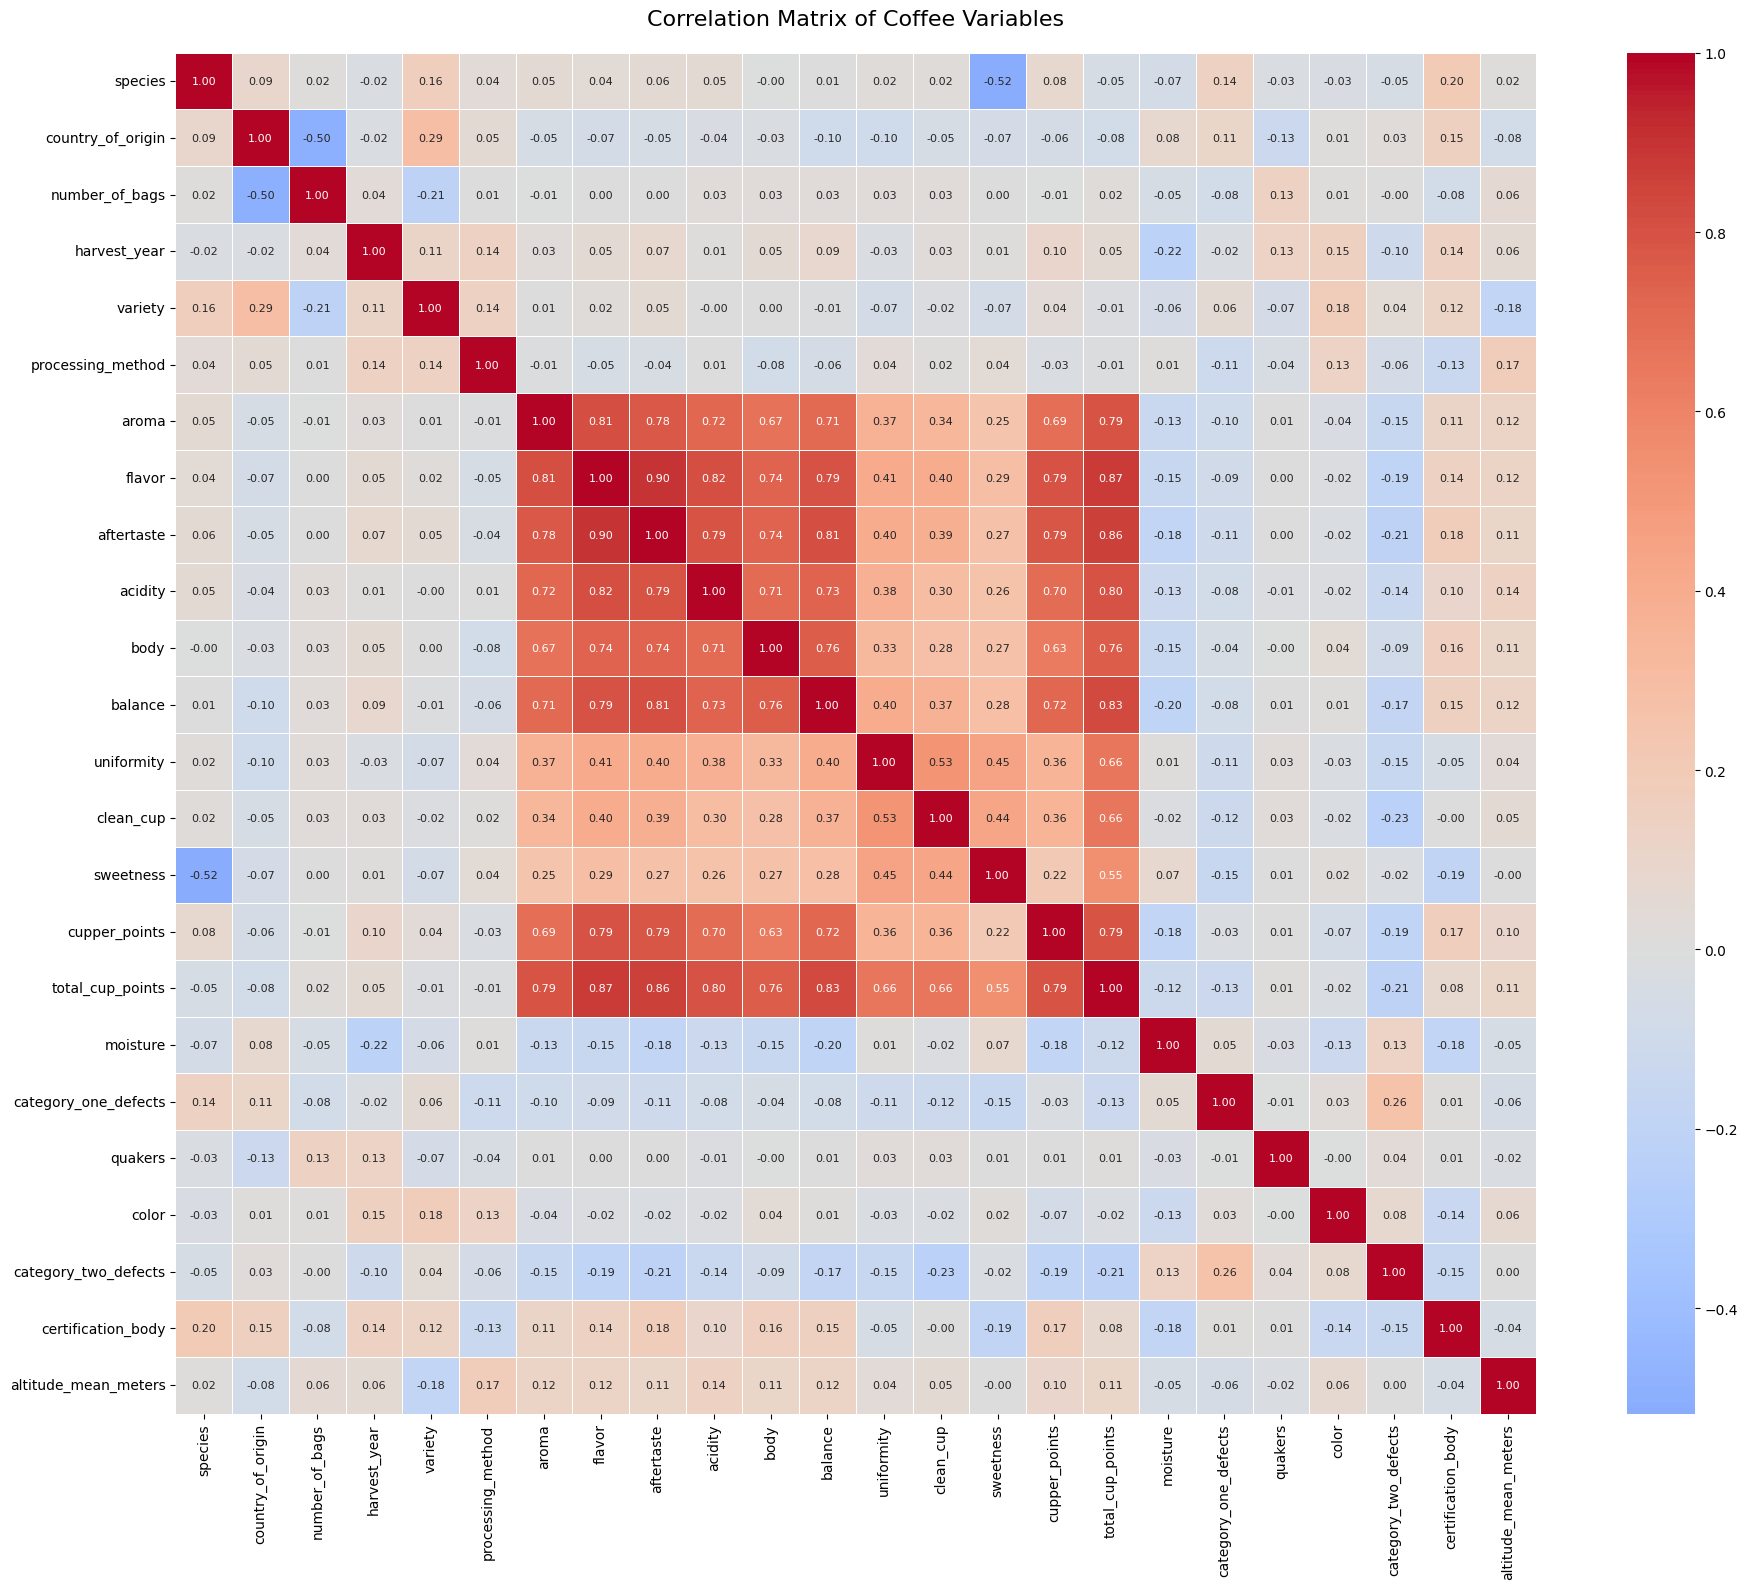


Strongest correlations:
aftertaste        flavor        0.895375
total_cup_points  flavor        0.874487
                  aftertaste    0.861213
                  balance       0.828683
acidity           flavor        0.816178
flavor            aroma         0.812723
balance           aftertaste    0.811316
total_cup_points  acidity       0.797053
cupper_points     flavor        0.793622
balance           flavor        0.793315
dtype: float64


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe to avoid modifying the original
df_corr = cleaned_df.copy()

# First, identify numeric and categorical columns
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
categorical_cols = df_corr.select_dtypes(include=['object']).columns

print("Numeric columns:", list(numeric_cols))
print("\nCategorical columns:", list(categorical_cols))

# Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Only encode if the column has less than 50 unique values to avoid too many categories
    if df_corr[col].nunique() < 50:
        df_corr[col] = label_encoder.fit_transform(df_corr[col].astype(str))
    else:
        df_corr = df_corr.drop(columns=[col])

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            square=True,  # Make the plot square-shaped
            fmt='.2f',  # Round correlation values to 2 decimal places
            annot_kws={'size': 8},  # Adjust size of correlation values
            linewidths=0.5)  # Add lines between cells

plt.title('Correlation Matrix of Coffee Variables', pad=20, size=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the strongest correlations
print("\nStrongest correlations:")

# Get the upper triangle of the correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Stack the correlations and sort by absolute value
strong_correlations = upper.unstack()
strong_correlations = strong_correlations[strong_correlations != 0].sort_values(key=abs, ascending=False)
print(strong_correlations.head(10))

In [16]:
# # Create correlation matrix for numerical columns (focusing on coffee qualities)
# quality_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body',
#        'balance', 'uniformity', 'clean_cup', 'sweetness', 'total_cup_points']
# correlation_matrix = cleaned_df.corr()

# # Create a heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation between Coffee Quality Attributes')

### Altitude versus total cup points

Text(0.5, 1.0, 'Altitude vs Total Cup Points')

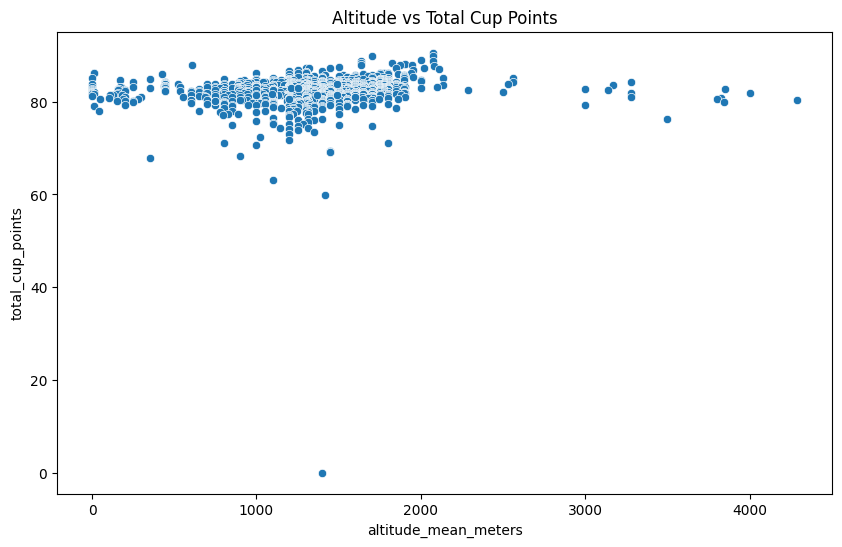

In [17]:
# Analyze relationship between altitude and coffee quality
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_df, x='altitude_mean_meters', y='total_cup_points')
plt.title('Altitude vs Total Cup Points')

### Quality scores by processing method

Text(0.5, 1.0, 'Quality Scores by Processing Method')

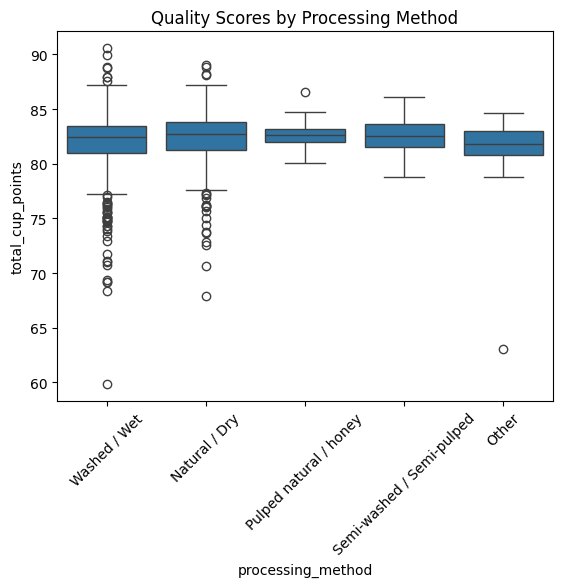

In [18]:
# Compare quality scores across processing methods
sns.boxplot(data=cleaned_df, x='processing_method', y='total_cup_points')
plt.xticks(rotation=45)
plt.title('Quality Scores by Processing Method')

In [19]:
# Average scores by region
avg_by_region = cleaned_df.groupby('region')['total_cup_points'].mean().sort_values(ascending=False)
print("\nAverage Scores by Region:")
print(avg_by_region)


Average Scores by Region:
region
guji-hambela                       89.776667
snnp/kaffa zone,gimbowereda        88.250000
oromiya                            88.125000
sulawesi                           87.420000
gedio                              87.250000
                                     ...    
marmelade                          72.330000
tlatlauquitepec                    71.080000
sierra norte yajalon, chiapas      70.750000
juchique de ferrer                 68.330000
department d'artibonite , haiti    67.920000
Name: total_cup_points, Length: 356, dtype: float64


### Average total cup points over the years

Original unique values:
['08/09 crop', '1T/2011', '1t/2011', '2009 - 2010', '2009 / 2010', '2009-2010', '2009/2010', '2010', '2010-2011', '2011', '2011/2012', '2012', '2013', '2013/2014', '2014', '2014/2015', '2015', '2015/2016', '2016', '2016 / 2017', '2016/2017', '2017', '2017 / 2018', '2018', '23 July 2010', '3T/2011', '47/2010', '4T/10', '4T/2010', '4T72010', '4t/2010', '4t/2011', 'Abril - Julio', 'Abril - Julio /2011', 'August to December', 'December 2009-March 2010', 'Fall 2009', 'January 2011', 'January Through April', 'March 2010', 'May-August', 'Mayo a Julio', 'Sept 2009 - April 2010', 'Spring 2011 in Colombia.', 'TEST', 'mmm']

Standardized unique values:
[np.float64(2009.0), np.float64(2010.0), np.float64(2011.0), np.float64(2012.0), np.float64(2013.0), np.float64(2014.0), np.float64(2015.0), np.float64(2016.0), np.float64(2017.0), np.float64(2018.0)]


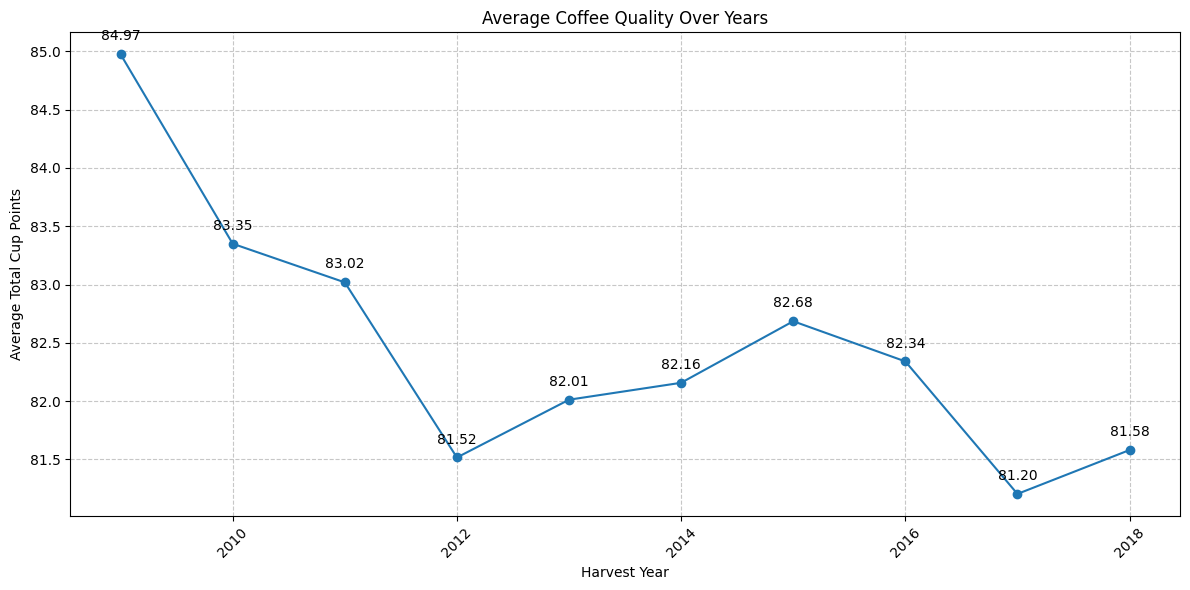


Number of entries per year:
harvest_year_standardized
2009.0     20
2010.0     30
2011.0     36
2012.0    354
2013.0    209
2014.0    252
2015.0    157
2016.0    131
2017.0     89
2018.0      1
Name: count, dtype: int64

Number of NaN values: 58


In [20]:
import pandas as pd
import numpy as np
import re

def standardize_harvest_year(year_str):
    if pd.isna(year_str):
        return np.nan
    
    # Convert to string in case it's already a number
    year_str = str(year_str).strip()
    
    # Simple year pattern (2000-2099)
    year_pattern = r'20[0-9]{2}'
    
    # Cases like '2009/2010' or '2009-2010' or '2009 - 2010'
    split_year_pattern = r'20[0-9]{2}[\s/\-]+20[0-9]{2}'
    
    # If it's a simple year, return it
    if re.match(r'^' + year_pattern + '$', year_str):
        return int(year_str)
    
    # If it's a split year pattern, take the first year
    elif re.match(split_year_pattern, year_str):
        return int(re.findall(year_pattern, year_str)[0])
    
    # Handle specific cases like '4T/10' or '1T/2011'
    elif '/10' in year_str or '/2010' in year_str:
        return 2010
    elif '/11' in year_str or '/2011' in year_str:
        return 2011
    
    # If there's any year in the string, extract the first one
    elif re.search(year_pattern, year_str):
        return int(re.findall(year_pattern, year_str)[0])
    
    # For all other cases, return NaN
    return np.nan

# Create a new column with standardized years
cleaned_df['harvest_year_standardized'] = cleaned_df['harvest_year'].apply(standardize_harvest_year)

# Display unique values before and after standardization
print("Original unique values:")
original_values = cleaned_df['harvest_year'].unique()
# Filter out NaN values for sorting strings
string_values = [str(x) for x in original_values if pd.notna(x)]
print(sorted(string_values))

print("\nStandardized unique values:")
standardized_values = cleaned_df['harvest_year_standardized'].unique()
# Filter out NaN values for sorting numbers
number_values = [x for x in standardized_values if pd.notna(x)]
print(sorted(number_values))

# Now we can create the time series plot with standardized years
yearly_avg = cleaned_df.groupby('harvest_year_standardized')['total_cup_points'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
yearly_avg.plot(kind='line', marker='o')
plt.title('Average Coffee Quality Over Years')
plt.xlabel('Harvest Year')
plt.ylabel('Average Total Cup Points')
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels
for x, y in yearly_avg.items():
    plt.annotate(f'{y:.2f}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nNumber of entries per year:")
print(cleaned_df['harvest_year_standardized'].value_counts().sort_index())
print("\nNumber of NaN values:", cleaned_df['harvest_year_standardized'].isna().sum())

In [21]:
cleaned_df['harvest_year_standardized']

0       2014.0
1       2014.0
2          NaN
3       2014.0
4       2014.0
         ...  
1334    2016.0
1335    2016.0
1336    2014.0
1337    2013.0
1338    2013.0
Name: harvest_year_standardized, Length: 1337, dtype: float64

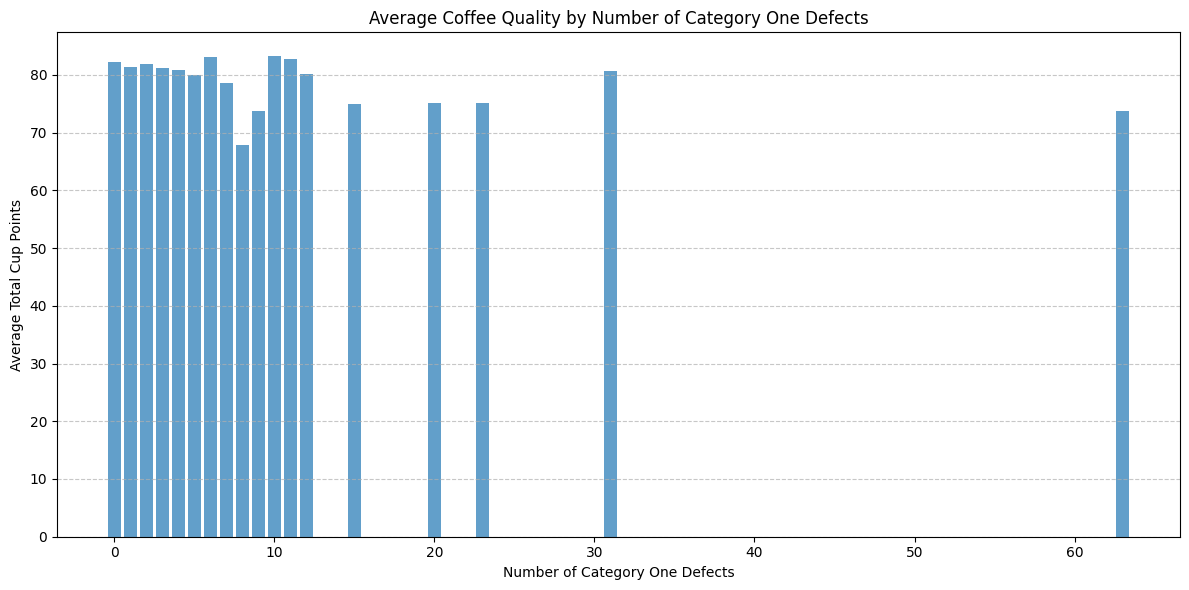

In [22]:
# Analyze impact of category one defects on quality

# Create a new figure
plt.figure(figsize=(12, 6))

# Calculate mean total cup points for each category_one_defects value
avg_quality = cleaned_df.groupby('category_one_defects')['total_cup_points'].mean().reset_index()

# Create bar plot
plt.bar(avg_quality['category_one_defects'], avg_quality['total_cup_points'], 
        alpha=0.7)

# Customize the plot
plt.title('Average Coffee Quality by Number of Category One Defects', fontsize=12)
plt.xlabel('Number of Category One Defects', fontsize=10)
plt.ylabel('Average Total Cup Points', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

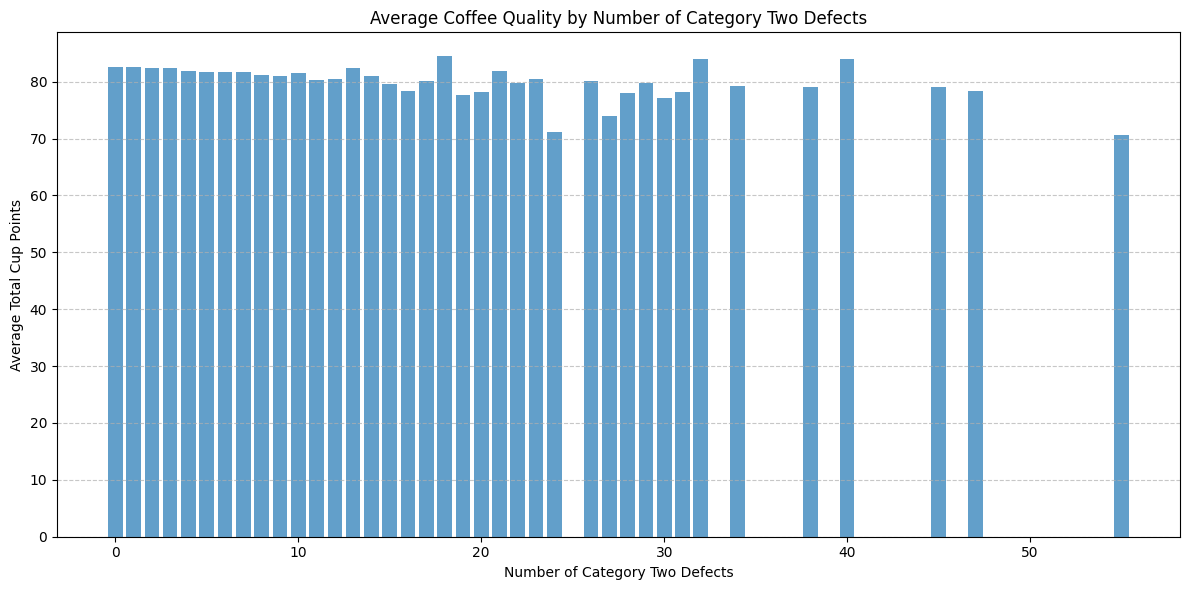

In [23]:
# Analyze impact of category two defects on quality

# Create a new figure
plt.figure(figsize=(12, 6))

# Calculate mean total cup points for each category_two_defects value
avg_quality = cleaned_df.groupby('category_two_defects')['total_cup_points'].mean().reset_index()

# Create bar plot
plt.bar(avg_quality['category_two_defects'], avg_quality['total_cup_points'], 
        alpha=0.7)

# Customize the plot
plt.title('Average Coffee Quality by Number of Category Two Defects', fontsize=12)
plt.xlabel('Number of Category Two Defects', fontsize=10)
plt.ylabel('Average Total Cup Points', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

## Post-process columns to include in the final dataset

### Replace nan values with the value "Other"

In [24]:
cleaned_df[['variety', 'processing_method']] = cleaned_df[['variety', 'processing_method']].fillna('Other')

### Remove robusta rows as they are highly sparse

In [25]:
cleaned_df = cleaned_df[cleaned_df['species'] != 'Robusta']

### Get class distributions

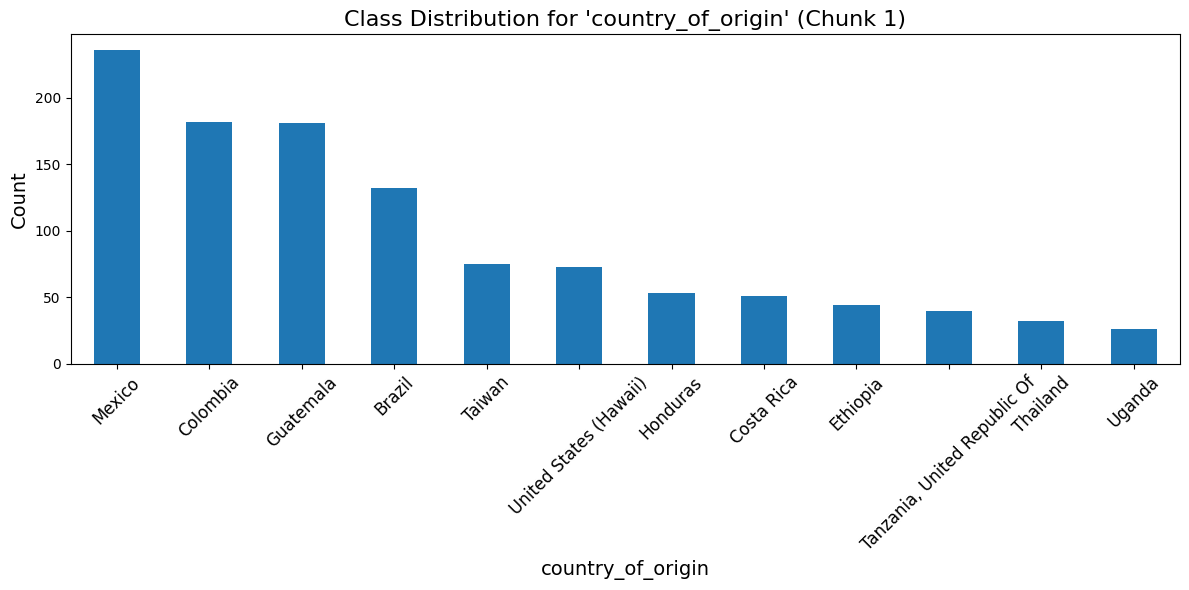

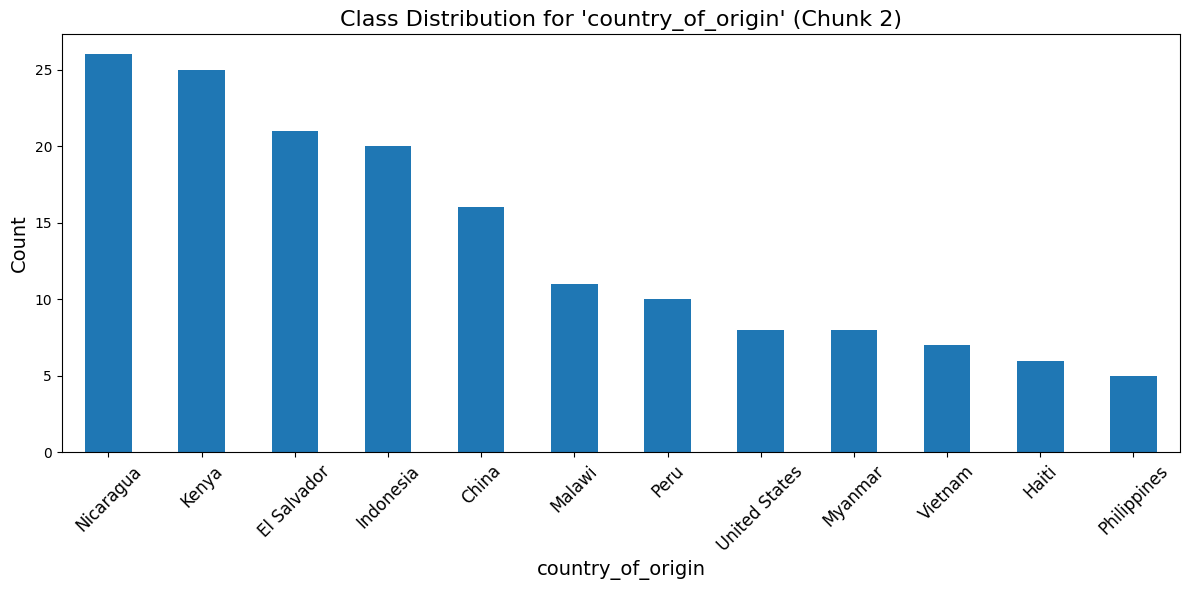

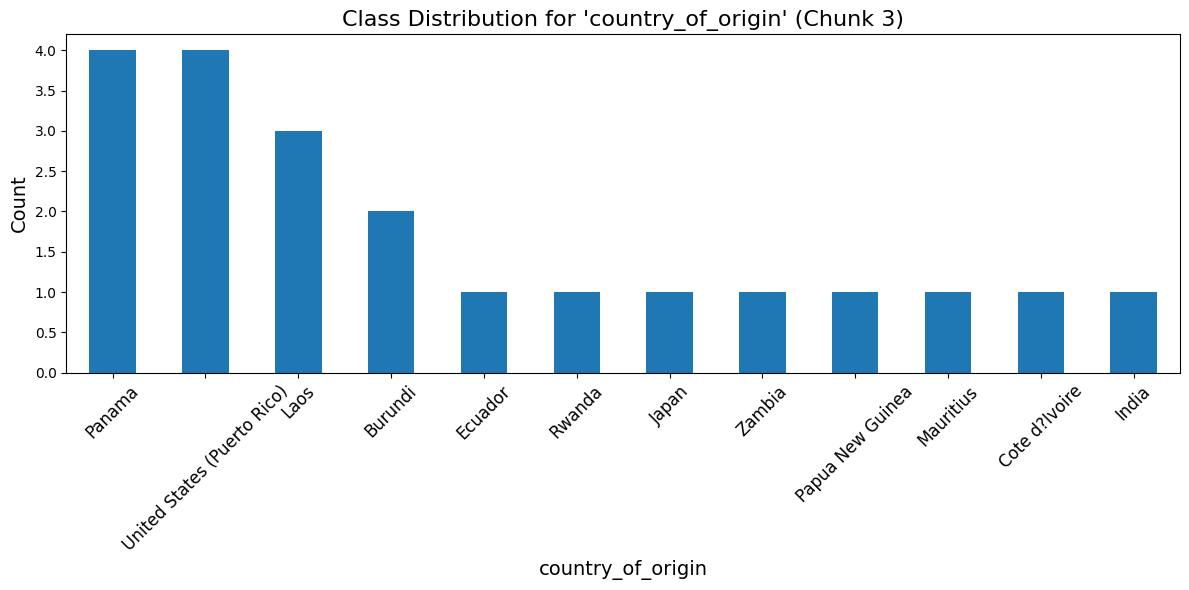

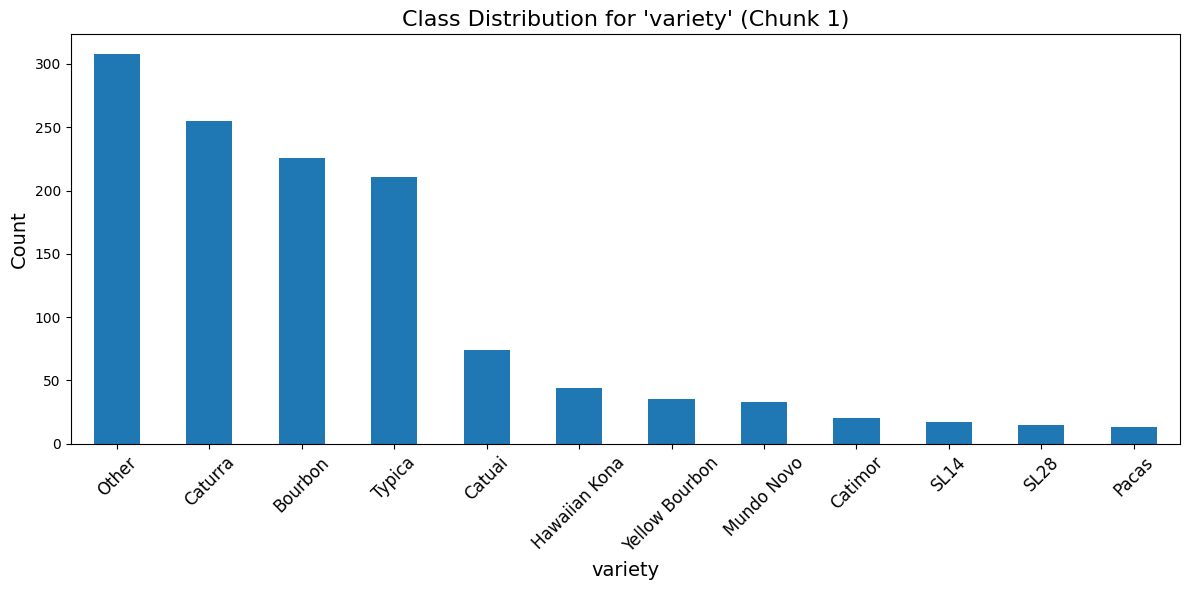

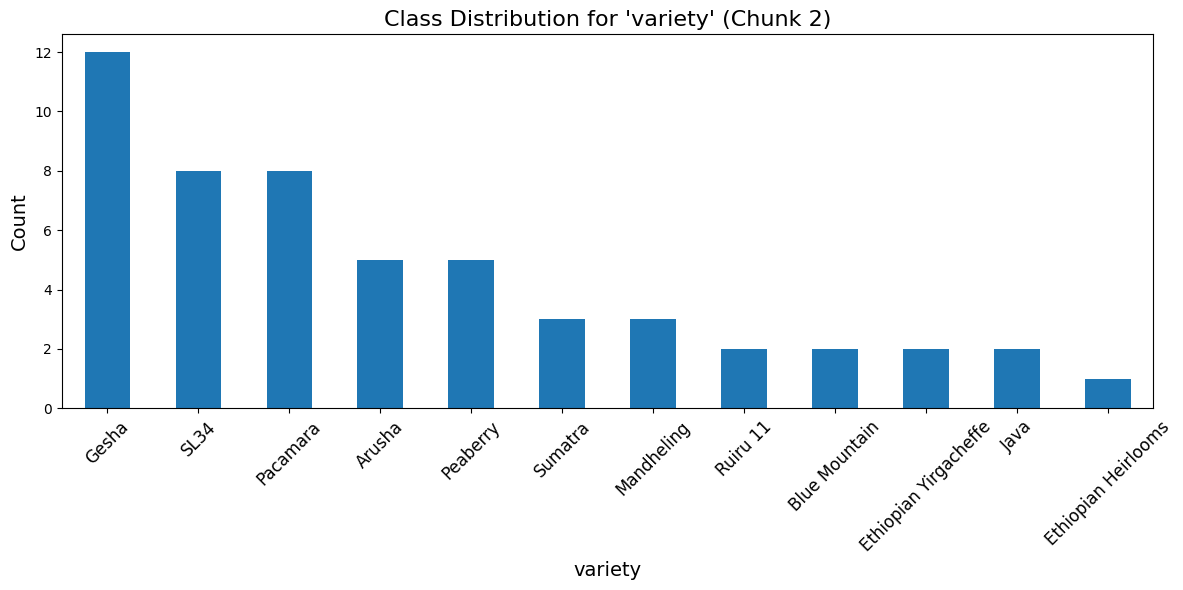

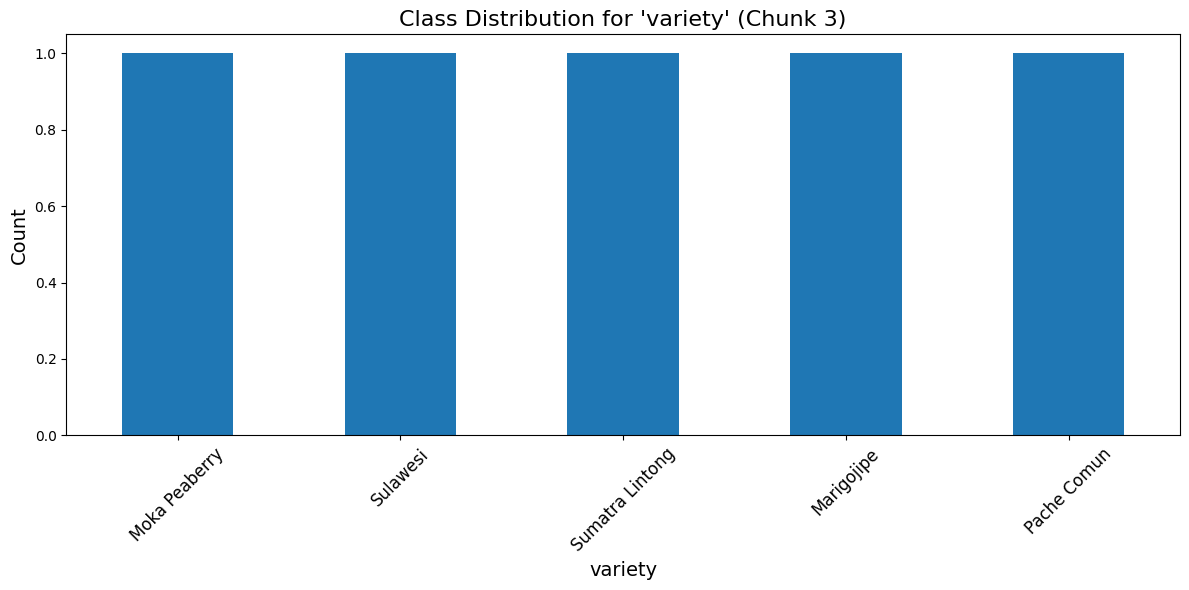

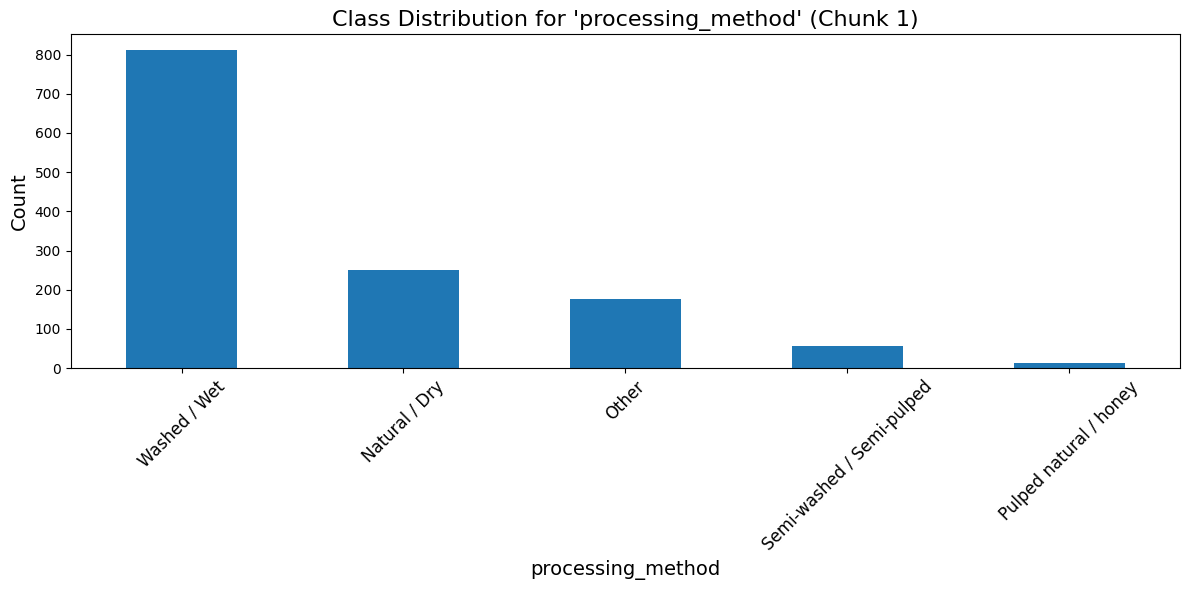

In [26]:
# Function to split and plot class distributions in chunks
def plot_class_distributions_in_chunks(df, column, chunk_size=12):
    unique_values = df[column].value_counts(dropna=False)
    total_chunks = (len(unique_values) + chunk_size - 1) // chunk_size  # Calculate total chunks
    
    for i in range(total_chunks):
        plt.figure(figsize=(12, 6))
        chunk = unique_values[i * chunk_size : (i + 1) * chunk_size]  # Select chunk
        chunk.plot(kind='bar')
        plt.title(f"Class Distribution for '{column}' (Chunk {i + 1})", fontsize=16)
        plt.xlabel(column, fontsize=14)
        plt.ylabel("Count", fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.tight_layout()
        plt.show()

# Plot distributions for the specified columns
for column in ['country_of_origin', 'variety', 'processing_method']:
    plot_class_distributions_in_chunks(cleaned_df, column, chunk_size=12)

### Write the cleaned dataframe into a CSV file dataset with the format $[X|y]$

In [27]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder

feature_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
                'balance', 'uniformity', 'clean_cup', 'sweetness']
label_cols = ['country_of_origin', 'variety', 'processing_method']

def create_datasets(cleaned_df, target_col='processing_method', smote_threshold=6):
    """
    Create balanced datasets using a combination of SMOTE and random oversampling
    
    Parameters:
    -----------
    cleaned_df : pandas.DataFrame
        Input DataFrame with all features and labels
    target_col : str, default='processing_method'
        Which label column to use for oversampling
    smote_threshold : int, default=6
        Minimum number of samples required for a class to use SMOTE
        
    Returns:
    --------
    tuple: (original_df, resampled_df)
    """
    # Reset index to ensure alignment
    cleaned_df = cleaned_df.reset_index(drop=True)
    
    # Original dataset
    X = cleaned_df[feature_cols]
    y = cleaned_df[label_cols]
    
    # Save original dataset
    combined_df = pd.concat([X, y], axis=1)
    combined_df.to_csv('datasets/preprocessed_coffee_data.csv', 
                      index=False, 
                      encoding='utf-8')
    
    # Print original class distribution
    print(f"\nOriginal class distribution for {target_col}:")
    original_dist = cleaned_df[target_col].value_counts()
    print(original_dist)
    
    # Split classes based on number of samples
    class_counts = cleaned_df[target_col].value_counts()
    smote_classes = class_counts[class_counts >= smote_threshold].index
    random_classes = class_counts[class_counts < smote_threshold].index
    
    print(f"\nClasses to be handled by SMOTE ({len(smote_classes)}):")
    print(smote_classes.tolist())
    print(f"\nClasses to be handled by random oversampling ({len(random_classes)}):")
    print(random_classes.tolist())
    
    try:
        # Create label encoders
        label_encoders = {}
        encoded_y = pd.DataFrame(index=cleaned_df.index)
        
        for col in label_cols:
            label_encoders[col] = LabelEncoder()
            encoded_y[col] = label_encoders[col].fit_transform(y[col])
        
        # Initialize final DataFrames list
        resampled_dfs = []
        
        # Step 1: Handle classes with sufficient samples using SMOTE
        if len(smote_classes) >= 2:  # Need at least 2 classes for SMOTE
            print("\nApplying SMOTE to classes with sufficient samples...")
            
            # Filter data for SMOTE
            smote_mask = cleaned_df[target_col].isin(smote_classes)
            X_smote = X[smote_mask].copy()
            y_smote = encoded_y[target_col][smote_mask].copy()
            
            # Determine k_neighbors based on minimum class size
            min_class_size = class_counts[smote_classes].min()
            k_neighbors = min(min_class_size - 1, 5)
            print(f"Using k_neighbors = {k_neighbors} for SMOTE")
            
            # Apply SMOTE
            smote = SMOTE(
                random_state=42,
                k_neighbors=k_neighbors,
                n_jobs=-1
            )
            X_smote_resampled, y_smote_resampled = smote.fit_resample(X_smote, y_smote)
            
            # Convert to DataFrame
            smote_df = pd.DataFrame(X_smote_resampled, columns=feature_cols)
            smote_df[target_col] = label_encoders[target_col].inverse_transform(y_smote_resampled)
            resampled_dfs.append(smote_df)
        
        # Step 2: Handle classes with insufficient samples using random oversampling
        if len(random_classes) > 0:
            print("\nApplying random oversampling to classes with insufficient samples...")
            
            # Filter data for random oversampling
            random_mask = cleaned_df[target_col].isin(random_classes)
            X_random = X[random_mask].copy()
            y_random = encoded_y[target_col][random_mask].copy()
            
            # Apply random oversampling
            ros = RandomOverSampler(random_state=42)
            X_random_resampled, y_random_resampled = ros.fit_resample(X_random, y_random)
            
            # Convert to DataFrame
            random_df = pd.DataFrame(X_random_resampled, columns=feature_cols)
            random_df[target_col] = label_encoders[target_col].inverse_transform(y_random_resampled)
            resampled_dfs.append(random_df)
        
        # Combine results if we have any resampled data
        if resampled_dfs:
            resampled_df = pd.concat(resampled_dfs, ignore_index=True)
            
            # Handle other label columns
            for col in label_cols:
                if col != target_col:
                    # Create a mapping of target to most common label
                    label_mapping = {}
                    for target_val in cleaned_df[target_col].unique():
                        mask = cleaned_df[target_col] == target_val
                        if mask.any():
                            most_common = cleaned_df[mask][col].mode()[0]
                            label_mapping[target_val] = most_common
                    
                    # Apply mapping
                    resampled_df[col] = resampled_df[target_col].map(label_mapping)
            
            # Print final class distribution
            print(f"\nFinal class distribution for {target_col}:")
            print(resampled_df[target_col].value_counts())
            
            # Save resampled dataset
            resampled_df.to_csv('datasets/preprocessed_coffee_data_resampled.csv', 
                               index=False, 
                               encoding='utf-8')
            
            # Print dataset sizes
            print(f"\nOriginal dataset size: {len(combined_df)}")
            print(f"Resampled dataset size: {len(resampled_df)}")
            
            return combined_df, resampled_df
        else:
            print("\nNo resampling was performed. Returning original dataset.")
            return combined_df, combined_df
        
    except Exception as e:
        print(f"\nError during resampling: {str(e)}")
        import traceback
        traceback.print_exc()
        print("Returning original dataset only")
        return combined_df, combined_df

def analyze_class_distributions(df):
    """
    Analyze class distributions for all label columns
    """
    print("\nClass distribution analysis:")
    for col in label_cols:
        dist = df[col].value_counts()
        ratio = dist.max() / dist.min()
        print(f"\n{col}:")
        print(f"Number of classes: {len(dist)}")
        print(f"Imbalance ratio (max/min): {ratio:.2f}")
        print("Top 5 most frequent classes:")
        print(dist.head())
        print("\nBottom 5 least frequent classes:")
        print(dist.tail())

# First analyze the distributions
print("Original data analysis:")
analyze_class_distributions(cleaned_df)

# Create both datasets
original_df, resampled_df = create_datasets(cleaned_df, target_col='processing_method', smote_threshold=6)

# Analyze class distributions for both datasets
print("\nOriginal Dataset:")
analyze_class_distributions(original_df)

print("\nResampled Dataset:")
analyze_class_distributions(resampled_df)

Original data analysis:

Class distribution analysis:

country_of_origin:
Number of classes: 36
Imbalance ratio (max/min): 236.00
Top 5 most frequent classes:
country_of_origin
Mexico       236
Colombia     182
Guatemala    181
Brazil       132
Taiwan        75
Name: count, dtype: int64

Bottom 5 least frequent classes:
country_of_origin
Zambia              1
Papua New Guinea    1
Mauritius           1
Cote d?Ivoire       1
India               1
Name: count, dtype: int64

variety:
Number of classes: 29
Imbalance ratio (max/min): 308.00
Top 5 most frequent classes:
variety
Other      308
Caturra    255
Bourbon    226
Typica     211
Catuai      74
Name: count, dtype: int64

Bottom 5 least frequent classes:
variety
Moka Peaberry      1
Sulawesi           1
Sumatra Lintong    1
Marigojipe         1
Pache Comun        1
Name: count, dtype: int64

processing_method:
Number of classes: 5
Imbalance ratio (max/min): 57.93
Top 5 most frequent classes:
processing_method
Washed / Wet              

/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [28]:
# feature_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
#                 'balance', 'uniformity', 'clean_cup', 'sweetness']
# label_cols = ['country_of_origin', 'variety', 'processing_method']

# X = cleaned_df[feature_cols]
# y  = cleaned_df[label_cols]

In [29]:
# # Concatenate X and y horizontally using pd.concat
# combined_df = pd.concat([X, y], axis=1)

# # Save to CSV
# # combined_df.to_csv('datasets/preprocessed_coffee_data.csv', 
# #                    index=False, 
# #                    encoding='utf-8'  # Specify encoding
# #                    )